# Cleaned data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
from scipy import stats 
from statsmodels.stats.weightstats import ztest


In [2]:
import warnings 
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_excel('../../HT_data/HT_table_20240227_clean_final.xlsx',sheet_name='All_clean') 
df.head()

,Group,Outcome,ID,Exam date,Gender,Age,TIME3,NIHSS,DM,Hypertension,...,EVT,IVT+EVT,ADC<620,Tmax>4 Volume,Tmax>6 Volume,Tmax>8 Volume,Tmax>10 Volume,PWI-DWI Mismatch,Tmax/DWI Ratio,VTmax>10s/VTmax>6s
0,0,0,327682,2018-01-02,M,78,3.0,2,0,0,...,0,0,0,79,0,0,0,0,NaN,0.0
1,0,0,371220,2018-01-09,M,79,7.5,1,0,1,...,0,0,12,18,0,0,0,-12,0.0,0.0
2,0,0,338762,2018-01-19,F,69,8.0,2,0,1,...,0,0,0,73,0,0,0,0,NaN,0.0
3,0,0,275353,2018-02-02,M,83,4.5,17,0,1,...,0,0,0,19,6,3,0,6,NaN,0.0
4,0,0,172077,2018-02-07,M,78,5.0,5,1,1,...,0,0,0,224,16,0,0,16,NaN,0.0


In [4]:
## convert gender FM ->01
def convert_gender(df):
    df['Gender']  =  [0 if gender == 'F' else 1 for gender in df['Gender']]
    return df 
df = convert_gender(df)

## convert mismatch < 0 -> = 0:
df['PWI-DWI Mismatch'][df['PWI-DWI Mismatch'] < 0] = 0 

df.head()

,Group,Outcome,ID,Exam date,Gender,Age,TIME3,NIHSS,DM,Hypertension,...,EVT,IVT+EVT,ADC<620,Tmax>4 Volume,Tmax>6 Volume,Tmax>8 Volume,Tmax>10 Volume,PWI-DWI Mismatch,Tmax/DWI Ratio,VTmax>10s/VTmax>6s
0,0,0,327682,2018-01-02,1,78,3.0,2,0,0,...,0,0,0,79,0,0,0,0,NaN,0.0
1,0,0,371220,2018-01-09,1,79,7.5,1,0,1,...,0,0,12,18,0,0,0,0,0.0,0.0
2,0,0,338762,2018-01-19,0,69,8.0,2,0,1,...,0,0,0,73,0,0,0,0,NaN,0.0
3,0,0,275353,2018-02-02,1,83,4.5,17,0,1,...,0,0,0,19,6,3,0,6,NaN,0.0
4,0,0,172077,2018-02-07,1,78,5.0,5,1,1,...,0,0,0,224,16,0,0,16,NaN,0.0


In [5]:
## find HT/nonHT result and fill nan
outcome = np.array(df['Group'])
## store index
index_ht = np.where(outcome==1)[0]
index_nonht = np.where(outcome==0)[0]


In [6]:
print('Number of Total samples: {}'.format(len(outcome)))
print('Number of HT samples: {}'.format(len(index_ht)))
print('Number of nonHT samples: {}'.format(len(index_nonht)))

Number of Total samples: 379
Number of HT samples: 131
Number of nonHT samples: 248


## Associated Disease

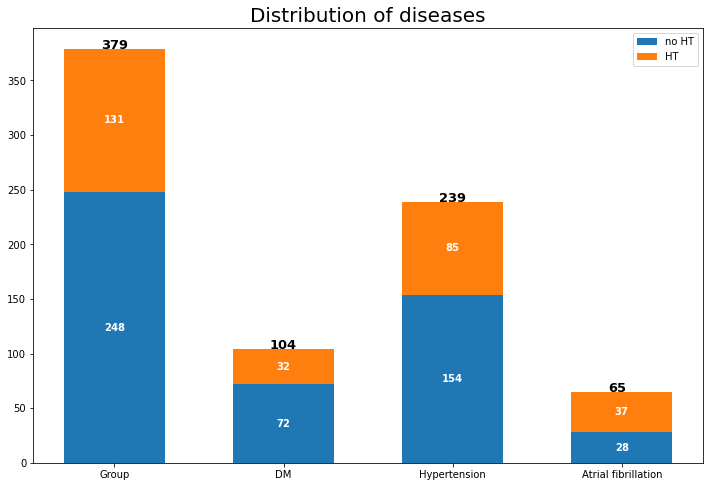

In [7]:
species = ('Group','DM', 'Hypertension', 'Atrial fibrillation')
def feature_stats(feature):
    feature_ls = df[feature]
    feature_ht = feature_ls[df['Group']==1]
    feature_nonht = feature_ls[df['Group']==0]
    return np.count_nonzero(feature_ls),np.count_nonzero(feature_ht),np.count_nonzero(feature_nonht)

counts = {'no HT':[len(df['Group'][df['Group']==0])],'HT':[len(df['Group'][df['Group']==1])]}


for i in range(1,len(species)):
    species_ls,species_ht,species_nonht = feature_stats(species[i])
    counts['no HT'].append(species_nonht)
    counts['HT'].append(species_ht)

width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(len(species))
labels = ['no HT','HT']
cnt = 0

for disease, disease_count in counts.items():
    p = ax.bar(species, disease_count, width,bottom=bottom,label = labels[cnt])
    bottom += disease_count
    ax.bar_label(p, label_type='center',color='white',weight="bold")
    cnt += 1
    
for i in range(len(species)):
    plt.text(i-0.08,counts['no HT'][i] + counts['HT'][i],counts['no HT'][i] + counts['HT'][i],fontsize=13,weight='bold')
    
ax.set_title('Distribution of diseases',fontsize=20)
ax.legend()

plt.show()

## Intervention

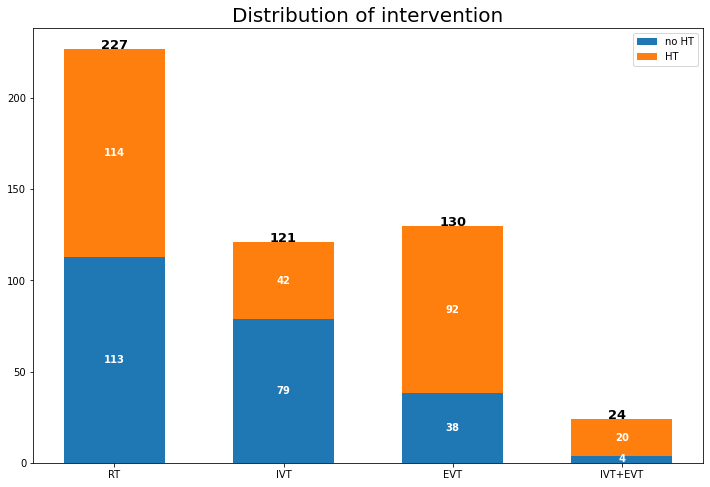

In [9]:
#1:静脉溶栓 2:动脉取栓

def find_intervention(feature):
    feature_ls = df[feature]
    feature_ht = feature_ls[df['Group']==1]
    feature_noht = feature_ls[df['Group'] == 0]
    return np.count_nonzero(feature_ht),np.count_nonzero(feature_noht)

species = ('RT','IVT', 'EVT', 'IVT+EVT')

counts = {
    'no HT': [],
    'HT': []
}

for i in range(len(species)):
    species_ht,species_nonht = find_intervention(species[i])
    counts['no HT'].append(species_nonht)
    counts['HT'].append(species_ht)
    
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(4)
labels = ['no HT','HT']
cnt = 0
for disease, disease_count in counts.items():
    p = ax.bar(species, disease_count, width,bottom=bottom,label = labels[cnt])
    bottom += disease_count
    ax.bar_label(p, label_type='center',color='white',weight="bold")
    cnt += 1
for i in range(len(species)):
    # plt.text(i-0.05,collection_intervention[i],collection_intervention[i],fontsize=13,weight='bold')
    plt.text(i-0.08,counts['no HT'][i] + counts['HT'][i],counts['no HT'][i] + counts['HT'][i],fontsize=13,weight='bold')
ax.set_title('Distribution of intervention',fontsize=20)
ax.legend()

plt.show()

## Relationship between intervention and TIME3 / Tmax 

In [10]:
df.columns

Index(['Group', 'Outcome', 'ID', 'Exam date', 'Gender', 'Age', 'TIME3',
       'NIHSS', 'DM', 'Hypertension', 'Atrial fibrillation', 'RT', 'RT.1',
       'IVT', 'EVT', 'IVT+EVT', 'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume',
       'Tmax>8 Volume', 'Tmax>10 Volume', 'PWI-DWI Mismatch', 'Tmax/DWI Ratio',
       'Tmax>10/>6s'],
      dtype='object')

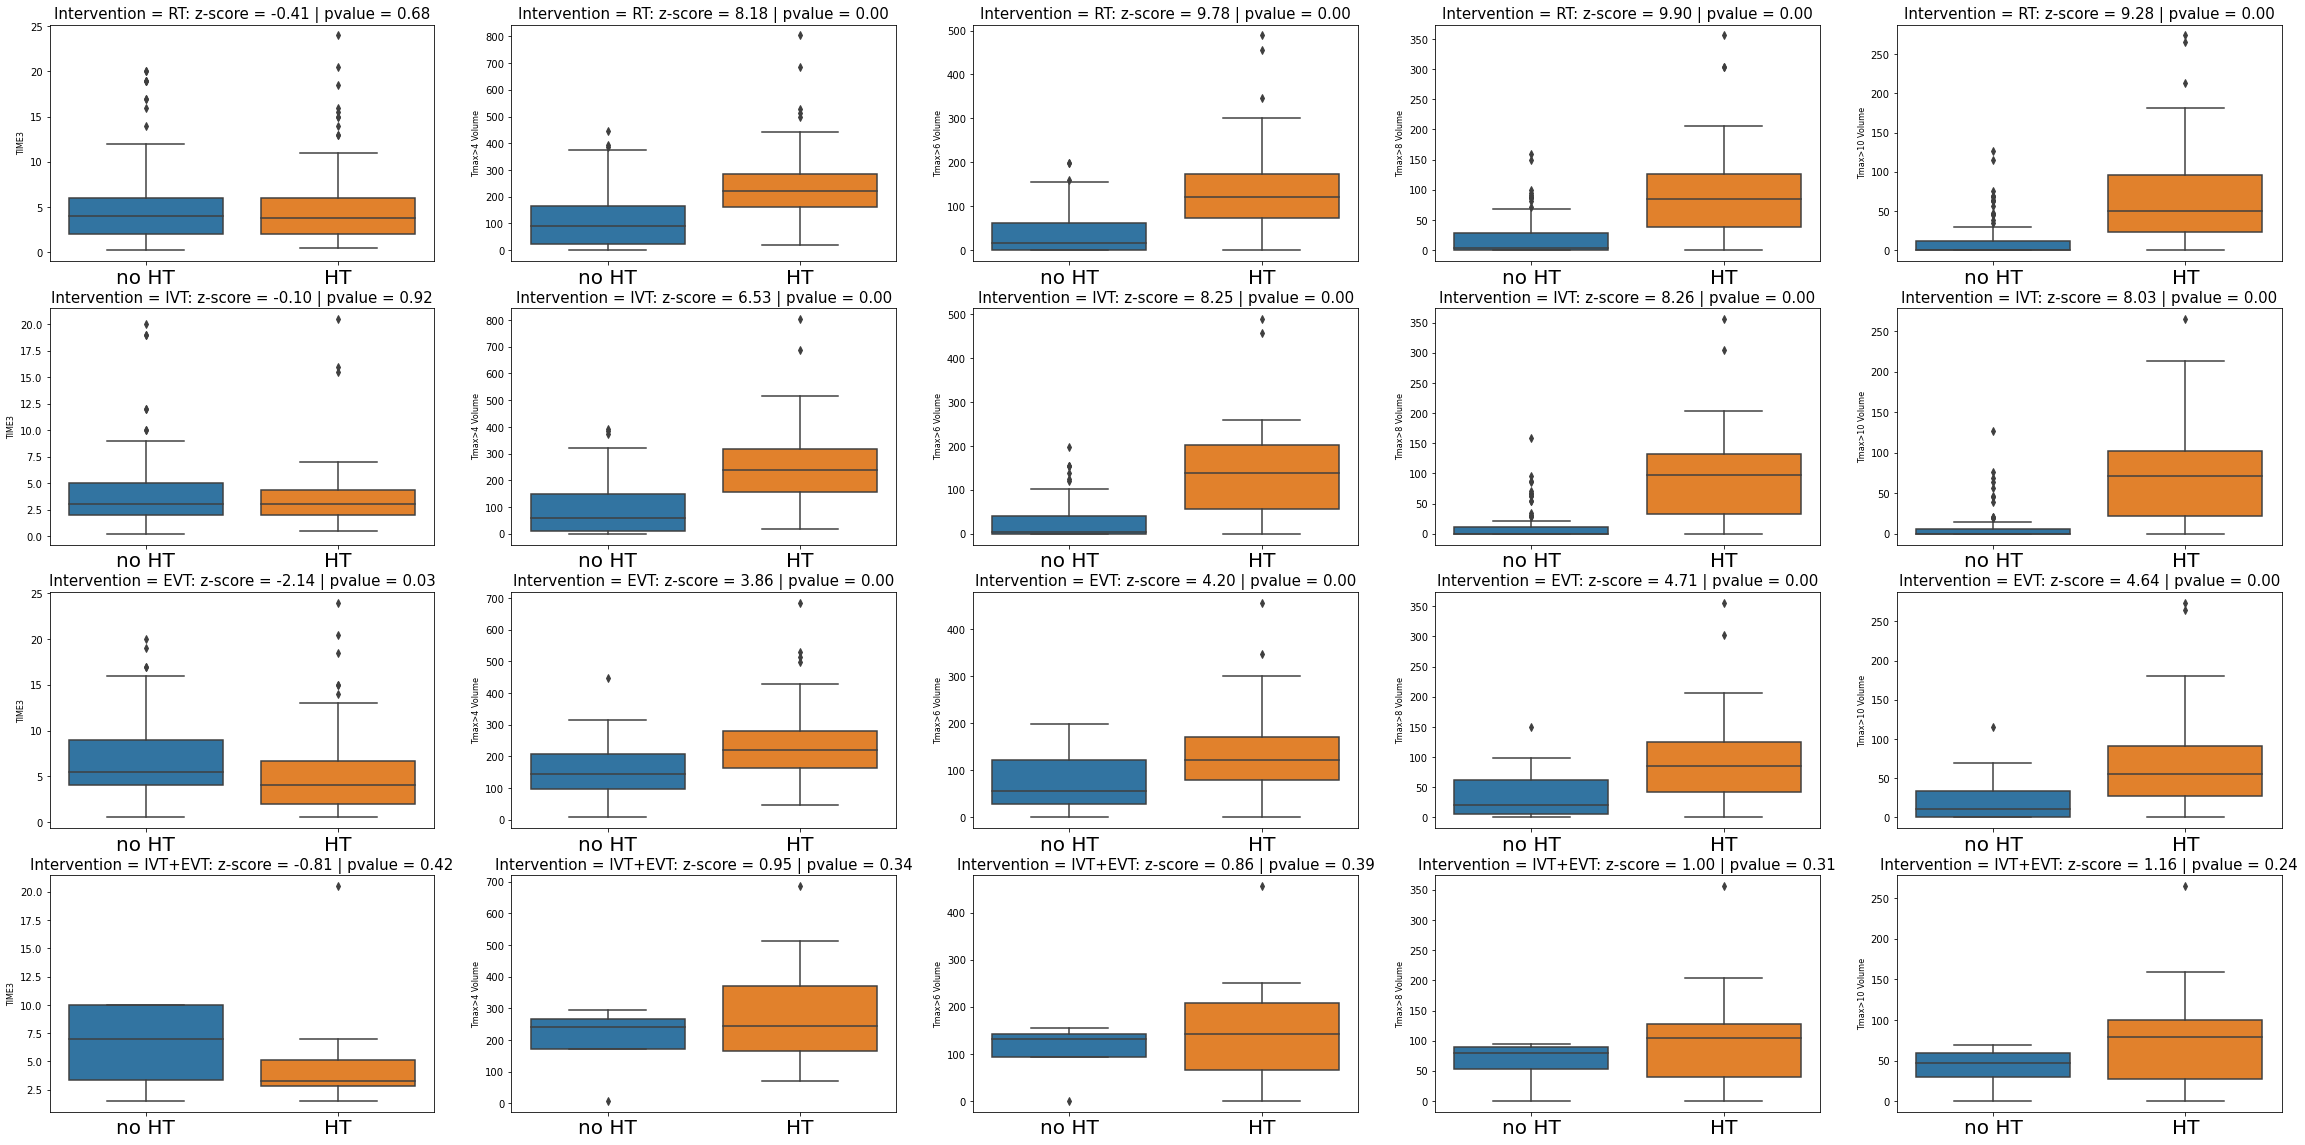

In [11]:
def intervention_pwi(intervention,y_label):
    # intervention = 'EVT'
     
    feature_ls = df[(df[intervention] == 1)] ## take this intervention
     
        
    # y_label = 'Tmax>6 Volume'
    feature_ht = feature_ls[df['Group']==1][y_label] ## after taking this intervention, for the HT people, look for its TIME3/Tmax
    feature_nonht = feature_ls[df['Group']==0][y_label]

    sns.boxplot(data=feature_ls,x='Group',y= y_label)
    plt.xlabel('')
    plt.xticks([0,1],['no HT','HT'],fontsize=20)
    zscore,pvalue = ztest(feature_ht,feature_nonht)
    title = 'Intervention = %s: z-score = %.2f | pvalue = %.2f'%(intervention,zscore,pvalue)
    plt.title(r'{}'.format(title),fontsize=15)
    plt.ylabel(y_label, fontsize=8)


plt.figure(figsize=(40,20))
intervention_types = ['RT','IVT','EVT','IVT+EVT']
pwi_types = ['TIME3','Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume', 'Tmax>10 Volume']
cnt = 1
for intervention in intervention_types:
    for pwi in pwi_types:
        plt.subplot(4,5,cnt)
        intervention_pwi(intervention,pwi)
        cnt += 1

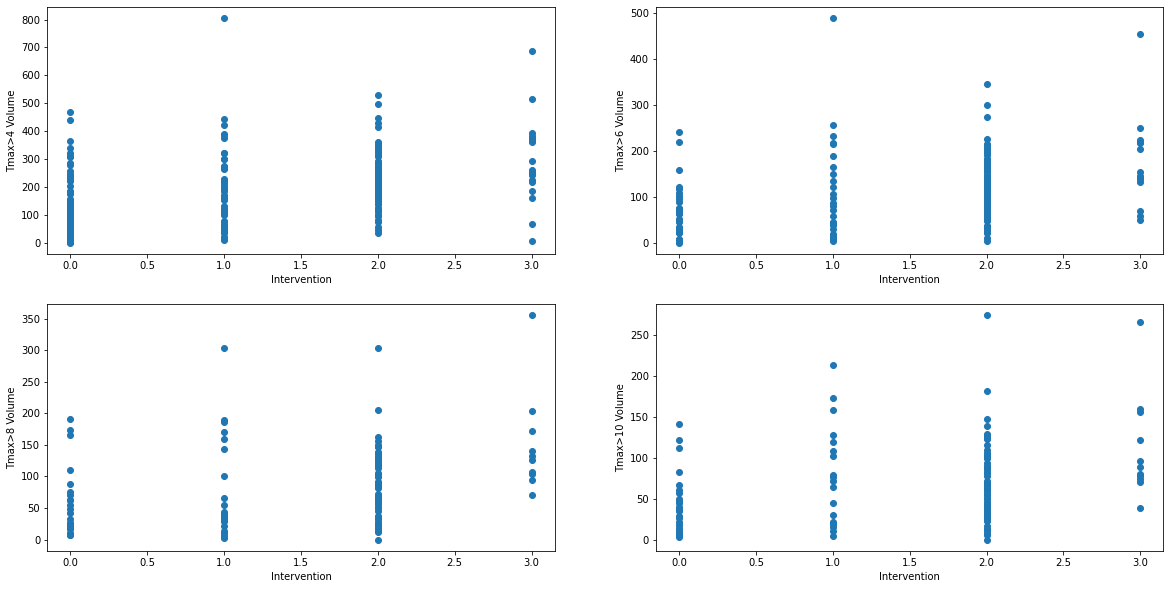

In [12]:
## Tmax 差不多，但intervention不同
tmax_types = ['Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume', 'Tmax>10 Volume']
intervention_types = ['IVT','EVT','IVT+EVT']

plt.figure(figsize=(20,10))
for k in range(len(tmax_types)):
    tmax_intervention = dict()
    tmax = df[tmax_types[k]].tolist()
    for i in range(len(tmax)):
        t = tmax[i]
        if df['RT'].iloc[i] == 0:
            tmax_intervention[t] = 0
        elif (df['IVT'].iloc[i] == 1) and (df['EVT'].iloc[i] == 0):
            tmax_intervention[t] = 1
        elif (df['IVT'].iloc[i] == 0) and (df['EVT'].iloc[i] == 1):
            tmax_intervention[t] = 2
        elif (df['IVT'].iloc[i] == 1) and (df['EVT'].iloc[i] == 1):
            tmax_intervention[t] = 3
    plt.subplot(2,2,k+1)
    plt.scatter(tmax_intervention.values(),tmax_intervention.keys())
    plt.ylabel(tmax_types[k])
    plt.xlabel('Intervention')
 

## Gender

In [13]:
## Gender
def gender_class(ls):
    index_male = np.where(ls==1)[0]
    index_female = np.where(ls==0)[0]
    return index_male,index_female
gender = np.array(df['Gender'])
index_male,index_female = gender_class(gender)
gender_ht = gender[index_ht]
index_male_ht,index_female_ht = gender_class(gender_ht)
gender_nonht = gender[index_nonht]
index_male_nonht,index_female_nonht = gender_class(gender_nonht)

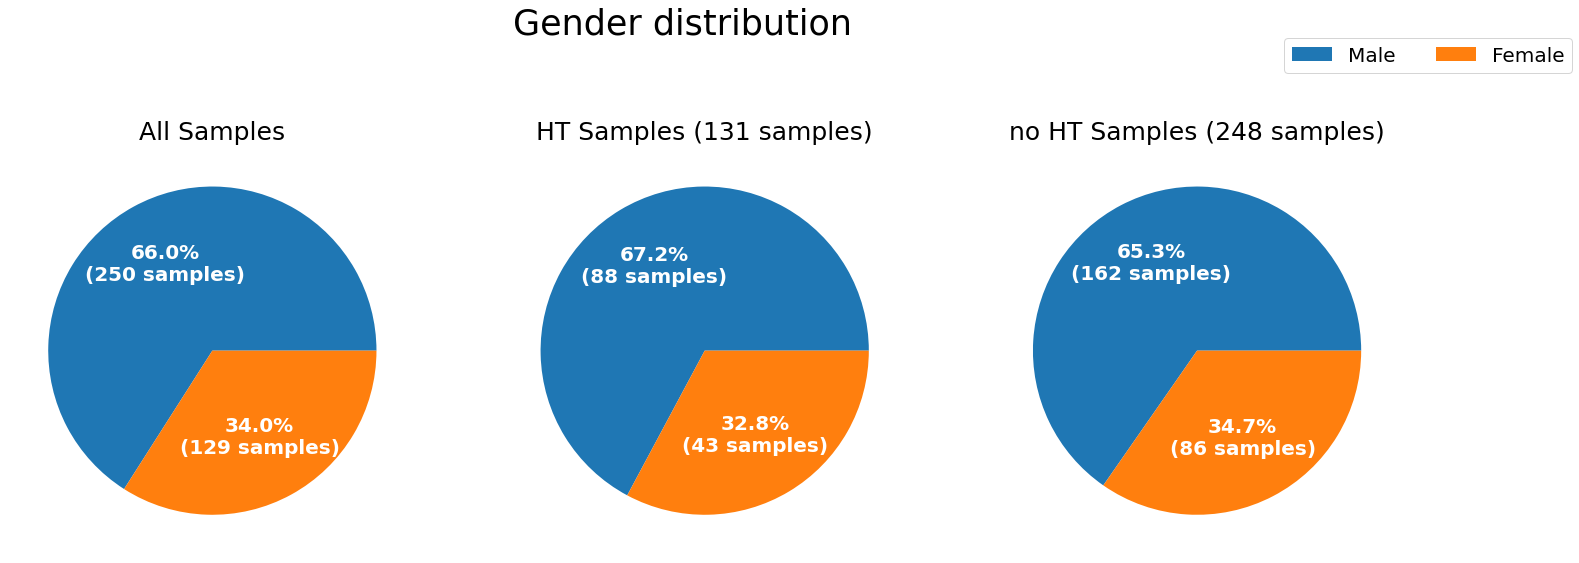

In [14]:
## basic pie chart
fig, axs = plt.subplots(1,3,figsize=(25, 10), subplot_kw=dict(aspect="equal"))

def draw_gender_piechart(data,index_ax,title):
    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n({absolute:d} samples)"
    wedges, texts, autotexts = axs[index_ax].pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
    plt.setp(autotexts, size=20, weight="bold")
    axs[index_ax].set_title(title,fontsize=25)
## all samples
draw_gender_piechart([len(index_male),len(index_female)],0,'All Samples')
draw_gender_piechart([len(index_male_ht),len(index_female_ht)],1,'HT Samples ({} samples)'.format(len(index_ht)))
draw_gender_piechart([len(index_male_nonht),len(index_female_nonht)],2,'no HT Samples ({} samples)'.format(len(index_nonht)))

labels = ['Male','Female']
fig.legend(labels,ncol=2,bbox_to_anchor=(1,0.95),prop = {'size':20})

plt.suptitle('Gender distribution',fontsize=35)
plt.show()

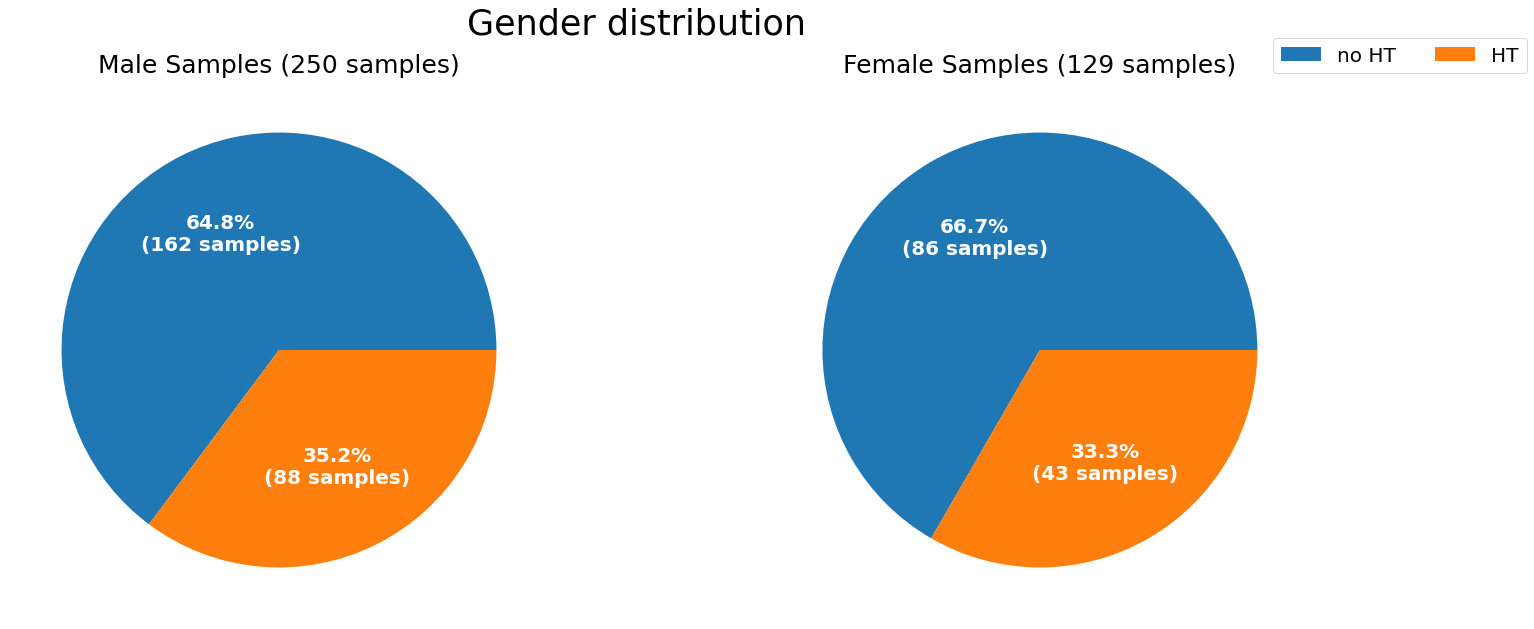

In [15]:
## basic pie chart
fig, axs = plt.subplots(1,2,figsize=(25, 10), subplot_kw=dict(aspect="equal"))

def draw_gender_piechart(data,index_ax,title):
    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n({absolute:d} samples)"
    wedges, texts, autotexts = axs[index_ax].pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
    plt.setp(autotexts, size=20, weight="bold")
    axs[index_ax].set_title(title,fontsize=25)
## all samples
draw_gender_piechart([len(index_male_nonht),len(index_male_ht)],0,'Male Samples ({} samples)'.format(len(index_male)))
draw_gender_piechart([len(index_female_nonht),len(index_female_ht)],1,'Female Samples ({} samples)'.format(len(index_female)))
 
labels = ['no HT','HT']
fig.legend(labels,ncol=2,bbox_to_anchor=(1,0.95),prop = {'size':20})

plt.suptitle('Gender distribution',fontsize=35)
plt.show()

## Age

In [16]:
age = np.array(df['Age'])
age_ht = age[index_ht]
age_nonht = age[index_nonht]

In [17]:
print('Range of age for HT samples: {} - {}'.format(np.min(age_ht),np.max(age_ht)))
print('Range of age for non HT samples: {} - {}'.format(np.min(age_nonht),np.max(age_nonht)))
print('Average of age for HT sampels: %.2f,std = %.2f'%(np.mean(age_ht),np.std(age_ht)))
print('Average of age for non HT sampels: %.2f,std = %.2f'%(np.mean(age_nonht),np.std(age_nonht)))

Range of age for HT samples: 48 - 93
Range of age for non HT samples: 24 - 96
Average of age for HT sampels: 72.36,std = 10.53
Average of age for non HT sampels: 70.25,std = 12.33


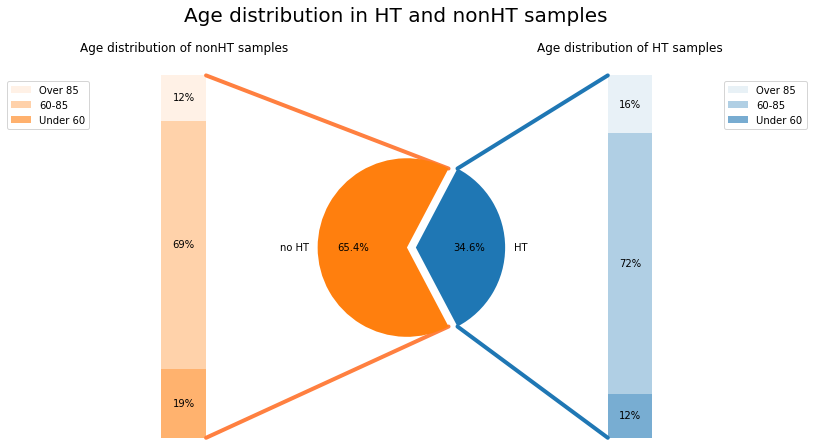

In [18]:
# make figure and assign axis objects
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [item/len(outcome) for item in [len(index_ht),len(index_nonht)]]
labels = ['HT', 'no HT']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle_ht = -180 * overall_ratios[0]
angle_nonht = -180 * overall_ratios[1]

## wedges 0:ht; wedges 1: nonht
wedges, *_ = ax2.pie(overall_ratios, autopct='%1.1f%%', startangle=angle_ht,
                     labels=labels, explode=explode)


age_labels = ['Under 60', '60-85', 'Over 85']
bottom = 1
width = .2
# bar chart 1 parameters
age_ratios_ht = [np.count_nonzero(age_ht<60)/len(index_ht),
              np.count_nonzero((age_ht>=60) & (age_ht<=85))/len(index_ht),
              np.count_nonzero(age_ht>85)/len(index_ht)]
# bar chart 2 parameters
age_ratios_nonht = [np.count_nonzero(age_nonht<60)/len(index_nonht),
              np.count_nonzero((age_nonht>=60) & (age_nonht<=85))/len(index_nonht),
              np.count_nonzero(age_nonht>85)/len(index_nonht)]


# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios_nonht, age_labels)])):
    bottom -= height
    bc = ax1.bar(0, height, width, bottom=bottom, color='C1', label=label,
                 alpha=0.1 + 0.25 * j)
    ax1.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    
    
for j, (height, label) in enumerate(reversed([*zip(age_ratios_ht, age_labels)])):
    bottom -= height
    bc = ax3.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax3.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')


ax1.set_title('Age distribution of nonHT samples')
ax1.legend(bbox_to_anchor=(0.1,0.95),prop = {'size':10})
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

ax3.set_title('Age distribution of HT samples')
ax3.legend(bbox_to_anchor=(0.9,0.95),prop = {'size':10})
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)


# use ConnectionPatch to draw lines between the two plots (ax3 and ax3)
# wedge0: ht
# wedge1: nonht
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r
bar_height_nonht = sum(age_ratios_nonht)

# nonht: draw top connecting line, with theta1
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(width / 2, bar_height_nonht), coordsA=ax1.transData,
                      xyB=(x, y), coordsB=ax2.transData)
con.set_color([1.0, 0.5, 0.25])
con.set_linewidth(4)
ax1.add_artist(con)

# nonht: draw bottom connecting line, with theta2
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(width / 2, 0), coordsA=ax1.transData,
                      xyB=(x, y), coordsB=ax2.transData)
con.set_color([1.0, 0.5, 0.25])
con.set_linewidth(4)
ax1.add_artist(con)


theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height_ht = sum(age_ratios_ht)

# ht: draw top connecting line, with theta2
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax3.transData,
                      xyB=(x, y), coordsB=ax2.transData)
con.set_color('C0')
con.set_linewidth(4)
ax1.add_artist(con)

# ht: draw bottom connecting line, with theta1
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -1), coordsA=ax3.transData,
                      xyB=(x, y), coordsB=ax2.transData)
con.set_color('C0')
con.set_linewidth(4)
ax1.add_artist(con)

plt.suptitle('Age distribution in HT and nonHT samples',fontsize=20)
plt.show()

## Features

In [7]:
# ## text descrption:
#     if text_des:
#         print('After data cleaning, number of total samples: %s'%(len(feature_ht)+len(feature_nonht)))
#         print('After data cleaning, number of HT samples: %s (%.4f %% of total samples)'%(len(feature_ht),100*len(feature_ht)/(len(feature_ht)+len(feature_nonht))))
#         print('Range of ' + feature + ' for HT samples: %s -> %s'%(np.min(feature_ht),np.max(feature_ht)))
#         print('Average of ' + feature + ' for HT sampels: %.4f'%(np.mean(feature_ht)))
#         print('STD of ' + feature + ' for HT sampels: %.4f'%(np.std(feature_ht)))
#         print('After data cleaning, number of non HT samples: %s (%.4f %% of total samples)'%(len(feature_nonht),100*len(feature_nonht)/(len(feature_ht)+len(feature_nonht))))
#         print('Range of ' + feature + ' non HT samples: %s -> %s'%(np.min(feature_nonht),np.max(feature_nonht)))
#         print('Average of ' + feature + ' for non HT sampels: %.4f'%(np.mean(feature_nonht)))
#         print('STD of ' + feature + ' for non HT sampels: %.4f'%(np.std(feature_nonht)))

In [7]:
from scipy.interpolate import InterpolatedUnivariateSpline 

In [8]:
def feature_stats_calculate(feature,z_test=False,other_test=False):

    discrete_features = ['Gender','DM','Hypertension','Atrial fibrillation','RT','IVT','EVT','IVT+EVT']
    ## box plot 
    if feature in discrete_features:
        sns.countplot(data=df, x=feature,hue='Group',palette="ch:.25")
        
        feature_ls = pd.to_numeric(df[feature])
        feature_ht = feature_ls[df['Group']==1]
        feature_nonht = feature_ls[df['Group']==0]  
    
        plt.xlabel('')
        plt.xticks(fontsize=35)
        plt.ylabel('')
        plt.yticks(fontsize=25)
        plt.legend(labels=['no HT','HT'],fontsize=25)
        
    else:
        sns.boxplot(data=df,x='Group',y=feature)
        
        feature_ls = pd.to_numeric(df[feature])
        feature_ht = feature_ls[df['Group']==1]
        feature_nonht = feature_ls[df['Group']==0]  
        
        plt.xlabel('')
        plt.xticks([0,1],['no HT','HT'],fontsize=35)
        plt.yticks(fontsize=25)
        plt.ylabel(feature, fontsize=35,labelpad=10)
    
    title = feature
    if z_test:
        zscore,pvalue = ztest(feature_ht,feature_nonht)
        if feature == 'TIME3':
            title = 'Time from MRI to onset' #: z-score = %.3f | pvalue = %.3f'%(zscore,pvalue)
        elif feature == 'DM':
            title = 'Diabetes mellitus' #: z-score = %.3f | pvalue = %.3f'%(zscore,pvalue)
        elif feature in ['ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume','Tmax>10 Volume', 'PWI-DWI Mismatch']:
            title = feature + ' (mL)'
        elif feature == 'VTmax>10s/VTmax>6s':
            title = '$V_{Tmax>10s}$/$V_{Tmax>6s}$'
        else:
            # title = '%s: z-score = %.3f | pvalue = %.3f'%(feature,zscore,pvalue)
            title = feature
    
    if other_test:
        if feature in discrete_features:    
            # chi2_contingency
            # This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table observed.
            # h0: the two groups have no significant difference
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html 
            feature_0_ht = len(df[df[feature] == 0][df['Group'] == 1])
            feature_1_ht = len(df[df[feature] == 1][df['Group'] == 1])
            feature_0_noht = len(df[df[feature] == 0][df['Group'] == 0])
            feature_1_noht = len(df[df[feature] == 1][df['Group'] == 0])
            chi_arr = [[feature_0_noht,feature_1_noht],[feature_0_ht,feature_1_ht]]
            chicore,pvalue,dof,expected = stats.chi2_contingency(chi_arr)
            title = '%s: chi-score = %.3f | pvalue = %.3f'%(feature,chicore,pvalue)
        else:
            # K-S test
            # Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
            # h0: two distributions are identical, F(x)=G(x) for all x
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp 
            ksscore,pvalue = stats.ks_2samp(feature_nonht,feature_ht)
            title = '%s: ks-score = %.3f | pvalue = %.3f'%(feature,ksscore,pvalue)
            
    
    plt.title(r'{}'.format(title),fontsize=45)
   
    
        

In [11]:
## find features
df.columns

Index(['Group', 'Outcome', 'ID', 'Exam date', 'Gender', 'Age', 'TIME3',
       'NIHSS', 'DM', 'Hypertension', 'Atrial fibrillation', 'RT', 'IVT',
       'EVT', 'IVT+EVT', 'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume',
       'Tmax>8 Volume', 'Tmax>10 Volume', 'PWI-DWI Mismatch', 'Tmax/DWI Ratio',
       'VTmax>10s/VTmax>6s'],
      dtype='object')

In [9]:
features = ['Gender',
              'Hypertension','DM','Atrial fibrillation',
              'Age',
              'NIHSS','TIME3',
              'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume','Tmax>10 Volume', 'PWI-DWI Mismatch','VTmax>10s/VTmax>6s']
len(features)

14

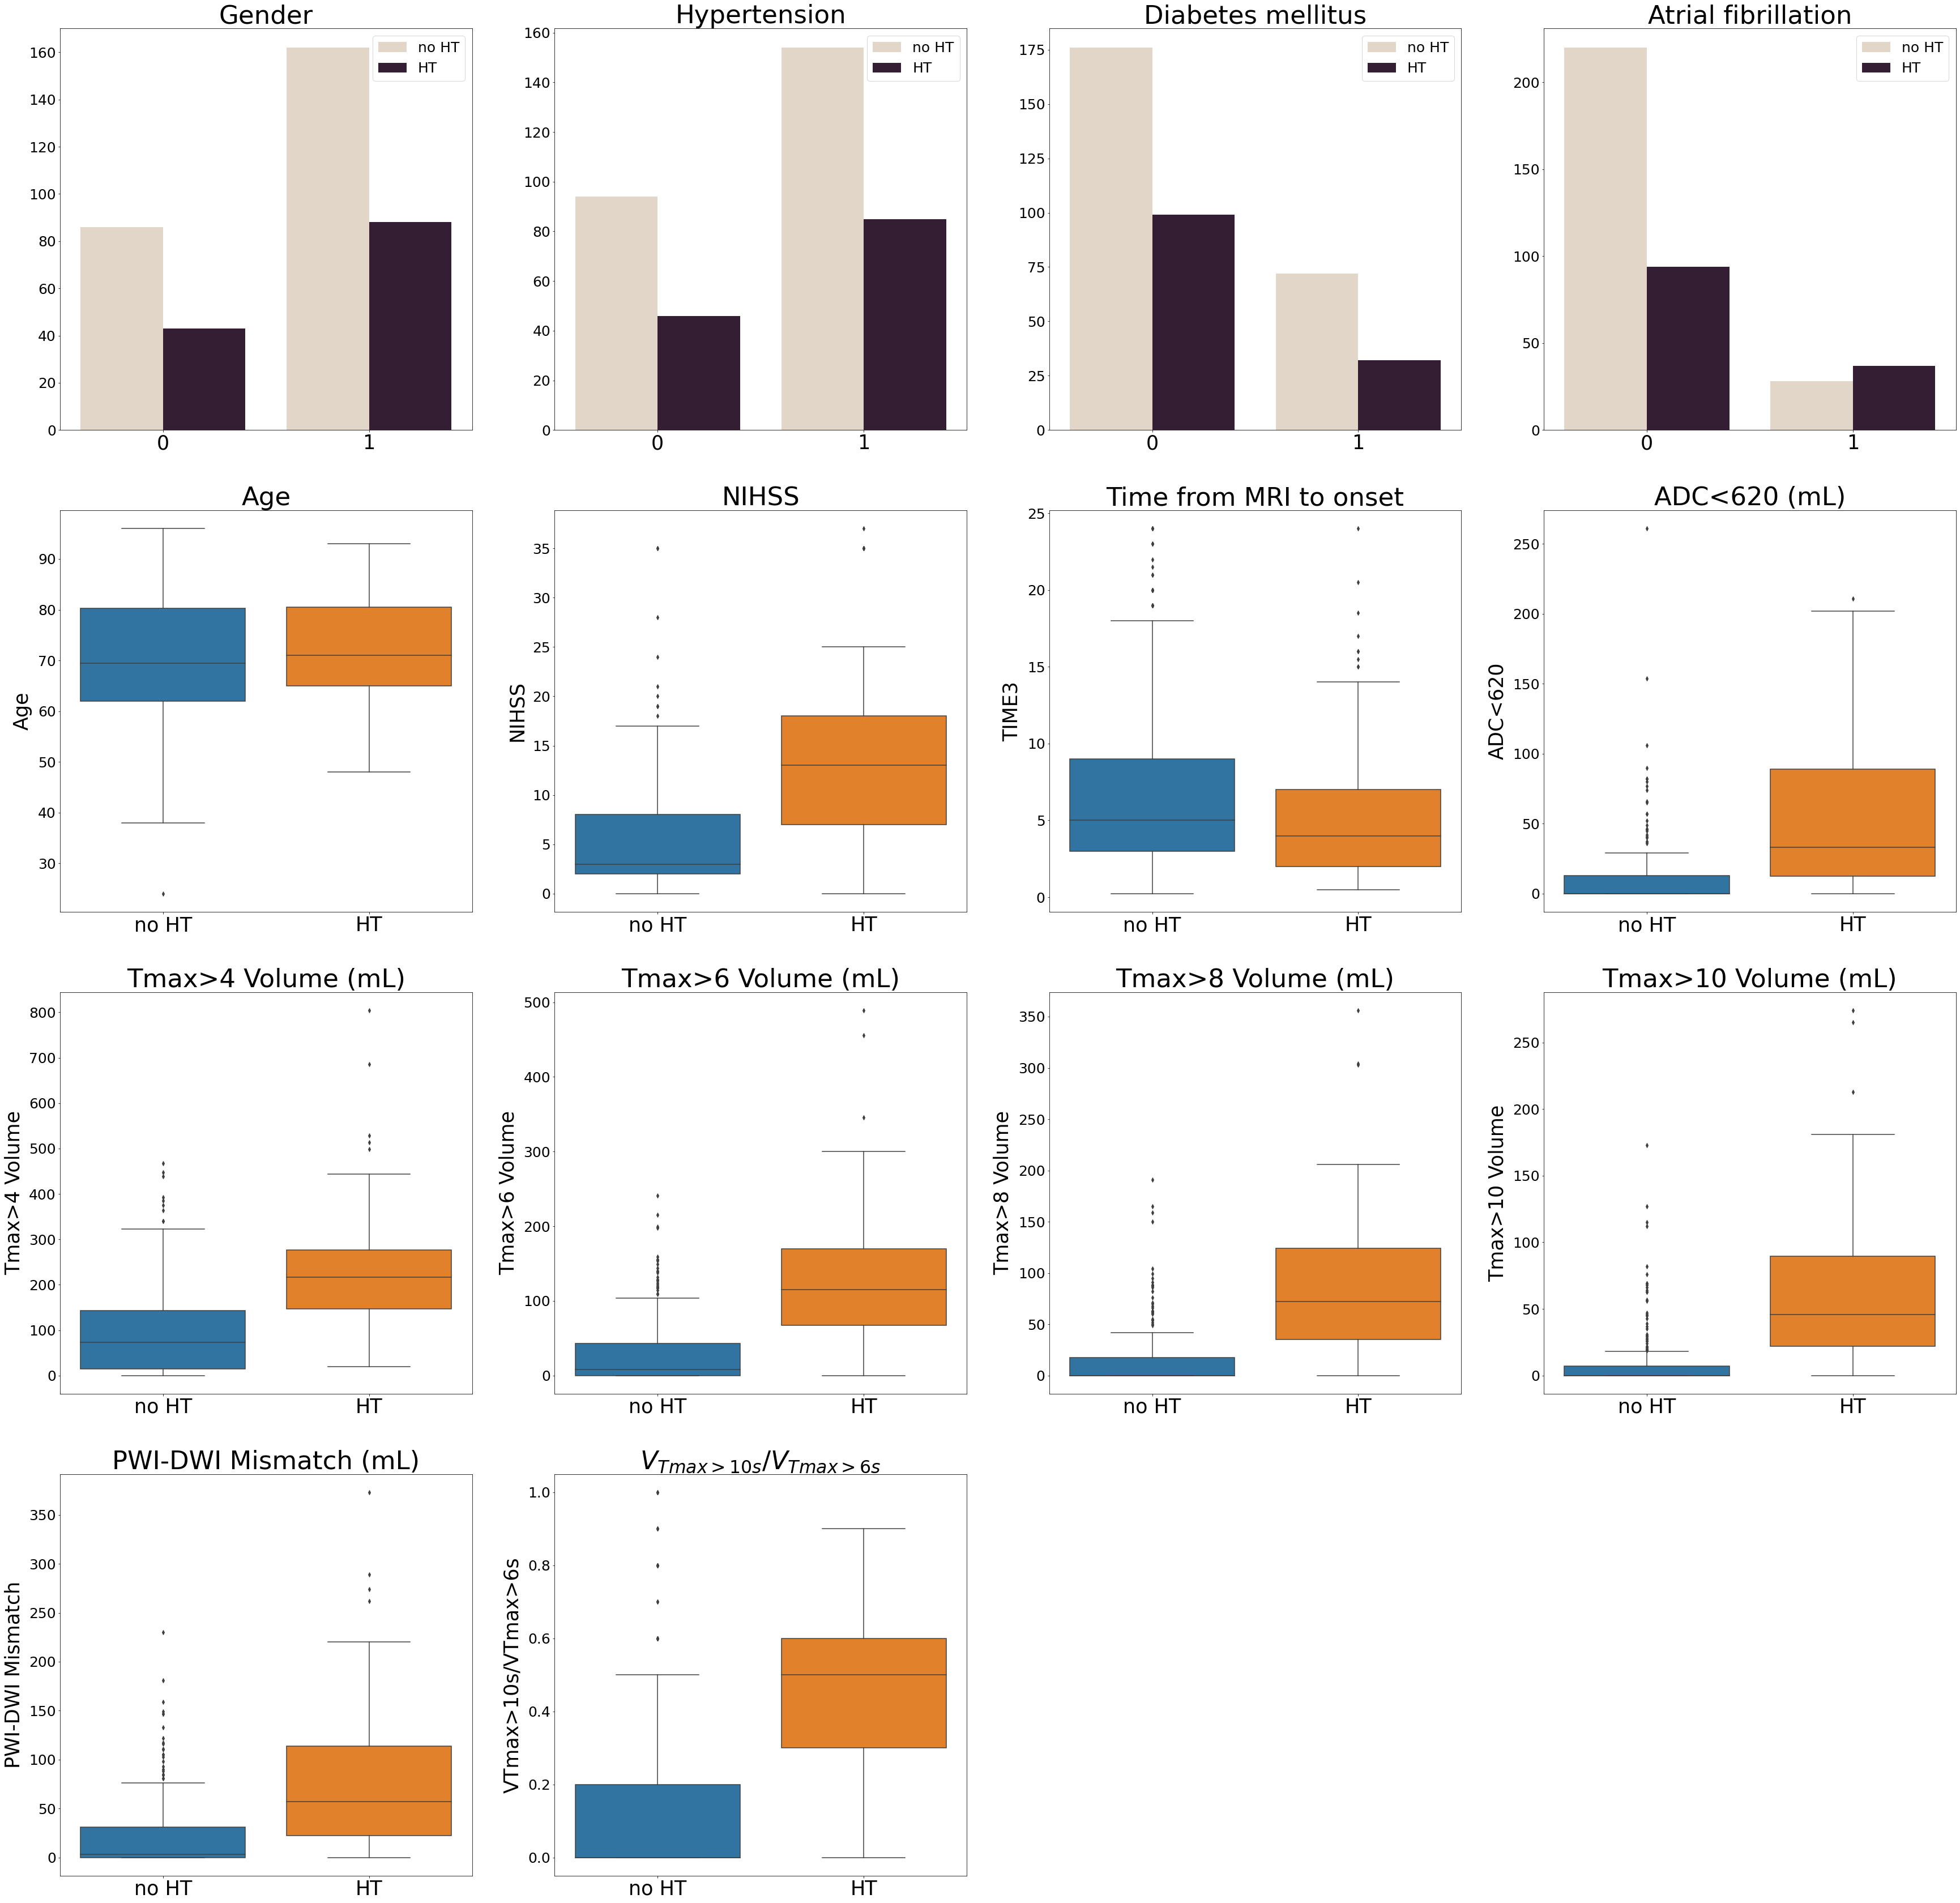

In [13]:
cnt = 1
plt.figure(figsize=(60,60))
for feature in features:
    # print('Calculating feature: {}...'.format(feature))
    plt.subplot(4,4,cnt)
    feature_stats_calculate(feature,z_test=True)
     
    cnt += 1
plt.savefig('figures/stats_ztest.jpg')
plt.show()

In [10]:
discrete_features = ['Gender','DM','Hypertension','Atrial fibrillation','RT','IVT','EVT','IVT+EVT']

In [11]:
for feature in features:
    if feature in discrete_features:    
        # chi2_contingency
        # This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table observed.
        # h0: the two groups have no significant difference
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html 
        feature_0_ht = len(df[df[feature] == 0][df['Group'] == 1])
        feature_1_ht = len(df[df[feature] == 1][df['Group'] == 1])
        feature_0_noht = len(df[df[feature] == 0][df['Group'] == 0])
        feature_1_noht = len(df[df[feature] == 1][df['Group'] == 0])
        chi_arr = [[feature_0_noht,feature_1_noht],[feature_0_ht,feature_1_ht]]
        chicore,pvalue,dof,expected = stats.chi2_contingency(chi_arr)
        title = '%s: chi-score = %.3f | pvalue = %.3f'%(feature,chicore,pvalue)
    else:
        # K-S test
        # Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
        # h0: two distributions are identical, F(x)=G(x) for all x
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp 
        feature_ls = pd.to_numeric(df[feature])
        feature_ht = feature_ls[df['Group']==1]
        feature_nonht = feature_ls[df['Group']==0]  
        ksscore,pvalue = stats.ks_2samp(feature_nonht,feature_ht)
        title = '%s: ks-score = %.3f | pvalue = %.3f'%(feature,ksscore,pvalue)
    # print(feature)
    print(title)
    print('*'*40)

Gender: chi-score = 0.062 | pvalue = 0.804
****************************************
Hypertension: chi-score = 0.179 | pvalue = 0.672
****************************************
DM: chi-score = 0.696 | pvalue = 0.404
****************************************
Atrial fibrillation: chi-score = 16.168 | pvalue = 0.000
****************************************
Age: ks-score = 0.106 | pvalue = 0.268
****************************************
NIHSS: ks-score = 0.501 | pvalue = 0.000
****************************************
TIME3: ks-score = 0.151 | pvalue = 0.035
****************************************
ADC<620: ks-score = 0.506 | pvalue = 0.000
****************************************
Tmax>4 Volume: ks-score = 0.522 | pvalue = 0.000
****************************************
Tmax>6 Volume: ks-score = 0.634 | pvalue = 0.000
****************************************
Tmax>8 Volume: ks-score = 0.640 | pvalue = 0.000
****************************************
Tmax>10 Volume: ks-score = 0.630 | pvalue = 0.000


In [32]:
for feature in features:
    print(feature)
    if feature == 'Gender':
        male = df[df[feature]==1]
        female = df[df[feature]==0]
        male_ht = male[df['Group']==1]
        male_nonht = male[df['Group']==0]
        female_ht = female[df['Group']==1]
        female_nonht = female[df['Group']==0]
        print('Male: Number in total %d (%.2f %%)'%(len(male),100*len(male)/(len(male)+len(female))))
        print('Male: Number of HT %d (%.2f %%)'%(len(male_ht),100*len(male_ht)/131))
        print('Male: Number of nonHT %d (%.2f %%)'%(len(male_nonht),100*len(male_nonht)/248))
        print('Female: Number in total %d (%.2f %%)'%(len(female),100*len(female)/(len(male)+len(female))))
        print('Female: Number of HT %d (%.2f %%)'%(len(female_ht),100*len(female_ht)/131))
        print('Female: Number of nonHT %d (%.2f %%)'%(len(female_nonht),100*len(female_nonht)/248))
        
        
    elif feature in ['Hypertension','DM','Atrial fibrillation','RT', 'IVT','EVT','IVT+EVT']:
        feature_ls = df[df[feature]==1]
        feature_ht = feature_ls[df['Group']==1]
        feature_nonht = feature_ls[df['Group']==0]
        print('Number in total %d (%.2f %%)'%(len(feature_ls),100*len(feature_ls)/len(df)))
        print('Number of HT %d (%.2f %%)'%(len(feature_ht),100*len(feature_ht)/131))
        print('Number of nonHT %d (%.2f %%)'%(len(feature_nonht),100*len(feature_nonht)/248))
        feature_ls = df[feature]
        feature_ht = feature_ls[df['Group']==1]
        feature_nonht = feature_ls[df['Group']==0]
        zscore,pvalue = ztest(feature_ht,feature_nonht)
        print('pvalue: %.4f'%(pvalue))
        
    elif feature in ['NIHSS','TIME3']:
        feature_ls = df[feature]
        feature_ht = feature_ls[df['Group'] == 1]
        feature_nonht = feature_ls[df['Group'] == 0]
        zscore,pvalue = ztest(feature_ht,feature_nonht)
        print('Total average: %.2f (%d - %d)'%(np.mean(feature_ls),np.min(feature_ls),np.max(feature_ls)))
        print('HT average: %.2f (%d - %d)'%(np.mean(feature_ht),np.min(feature_ht),np.max(feature_ht)))
        print('nonHT average: %.2f(%d - %d)'%(np.mean(feature_nonht),np.min(feature_nonht),np.max(feature_nonht)))
        print('pvalue: %.4f'%(pvalue))
        
    else:
        feature_ls = df[feature]
        feature_ht = feature_ls[df['Group'] == 1]
        feature_nonht = feature_ls[df['Group'] == 0]
        zscore,pvalue = ztest(feature_ht,feature_nonht)
        print('Total average ± std: %.2f ± %.2f'%(np.mean(feature_ls),np.std(feature_ls)))
        print('HT average ± std: %.2f ± %.2f'%(np.mean(feature_ht),np.std(feature_ht)))
        print('nonHT average ± std: %.2f ± %.2f'%(np.mean(feature_nonht),np.std(feature_nonht)))
        print('pvalue: %.4f'%(pvalue))
    print('*'*100)      

Gender
Male: Number in total 250 (65.96 %)
Male: Number of HT 88 (67.18 %)
Male: Number of nonHT 162 (65.32 %)
Female: Number in total 129 (34.04 %)
Female: Number of HT 43 (32.82 %)
Female: Number of nonHT 86 (34.68 %)
****************************************************************************************************
Hypertension
Number in total 239 (63.06 %)
Number of HT 85 (64.89 %)
Number of nonHT 154 (62.10 %)
pvalue: 0.5935
****************************************************************************************************
DM
Number in total 104 (27.44 %)
Number of HT 32 (24.43 %)
Number of nonHT 72 (29.03 %)
pvalue: 0.3400
****************************************************************************************************
Atrial fibrillation
Number in total 65 (17.15 %)
Number of HT 37 (28.24 %)
Number of nonHT 28 (11.29 %)
pvalue: 0.0000
****************************************************************************************************
Age
Total average ± std: 70.98 ± 11.78
H

## Correlation 1

In [10]:
useful_data = pd.DataFrame(df,columns=['Age','Gender','Hypertension', 'Atrial fibrillation','DM','TIME3', 
                                       'NIHSS', 'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume','Tmax>10 Volume', 
                                       'PWI-DWI Mismatch','VTmax>10s/VTmax>6s','Group'])
useful_data = useful_data.apply(lambda x:x.astype(float))
useful_data.head()

,Age,Gender,Hypertension,Atrial fibrillation,DM,TIME3,NIHSS,ADC<620,Tmax>4 Volume,Tmax>6 Volume,Tmax>8 Volume,Tmax>10 Volume,PWI-DWI Mismatch,VTmax>10s/VTmax>6s,Group
0,78.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0
1,79.0,1.0,1.0,0.0,0.0,7.5,1.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0
3,83.0,1.0,1.0,0.0,0.0,4.5,17.0,0.0,19.0,6.0,3.0,0.0,6.0,0.0,0.0
4,78.0,1.0,1.0,0.0,1.0,5.0,5.0,0.0,224.0,16.0,0.0,0.0,16.0,0.0,0.0


In [11]:
correlation_matrix = useful_data.corr()
correlation_matrix = np.array(correlation_matrix) 
correlation_matrix[np.triu_indices(correlation_matrix.shape[0], 0)] = np.nan

pvalue_matrix = useful_data.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
pvalue_matrix = pvalue_matrix.round(4)

## standard
## null hypothesis: not related 
## * : correlation is significant at 0.05 level (2 tailed)
## ** : correlation is significant at 0.01 level (2 tailed)
## *** : correlation is significant at 0.001 level (2 tailed)

correlation_pmatrix = np.array(correlation_matrix.round(4),dtype='str') 
pvalue_matrix = np.array(pvalue_matrix)
for i in range(correlation_pmatrix.shape[0]):
    for j in range(correlation_pmatrix.shape[1]):
        if i > j:
            if (pvalue_matrix[i][j] < 0.001/2) or (pvalue_matrix[i][j] > 1-0.001/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n***'
            elif (pvalue_matrix[i][j] < 0.01/2) or (pvalue_matrix[i][j] > 1-0.01/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n**'
            elif (pvalue_matrix[i][j] < 0.05/2) or (pvalue_matrix[i][j] > 1-0.05/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n*'
        
correlation_pmatrix = pd.DataFrame(correlation_pmatrix,columns=useful_data.columns)

In [12]:
print(useful_data.columns[:-1])
print(useful_data.columns[1:])

Index(['Age', 'Gender', 'Hypertension', 'Atrial fibrillation', 'DM', 'TIME3',
       'NIHSS', 'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume',
       'Tmax>10 Volume', 'PWI-DWI Mismatch', 'VTmax>10s/VTmax>6s'],
      dtype='object')
Index(['Gender', 'Hypertension', 'Atrial fibrillation', 'DM', 'TIME3', 'NIHSS',
       'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume',
       'Tmax>10 Volume', 'PWI-DWI Mismatch', 'VTmax>10s/VTmax>6s', 'Group'],
      dtype='object')


In [13]:
xticklabel = ['Age', 'Gender', 'Hypertension', 'Atrial fibrillation', 'Diabetes mellitus', 'Time from onset to MRI',
       'NIHSS score at admission', '$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$', 'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s',
       'Tmax > 10 s', 'PWI-DWI mismatch', 'HIR']
yticklabel = ['Gender', 'Hypertension', 'Atrial fibrillation', 'Diabetes mellitus', 'Time from onset to MRI', 'NIHSS score at admission',
       '$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$', 'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s',
       'Tmax > 10 s', 'PWI-DWI mismatch', 'HIR', 'Outcome (HT or non-HT)']

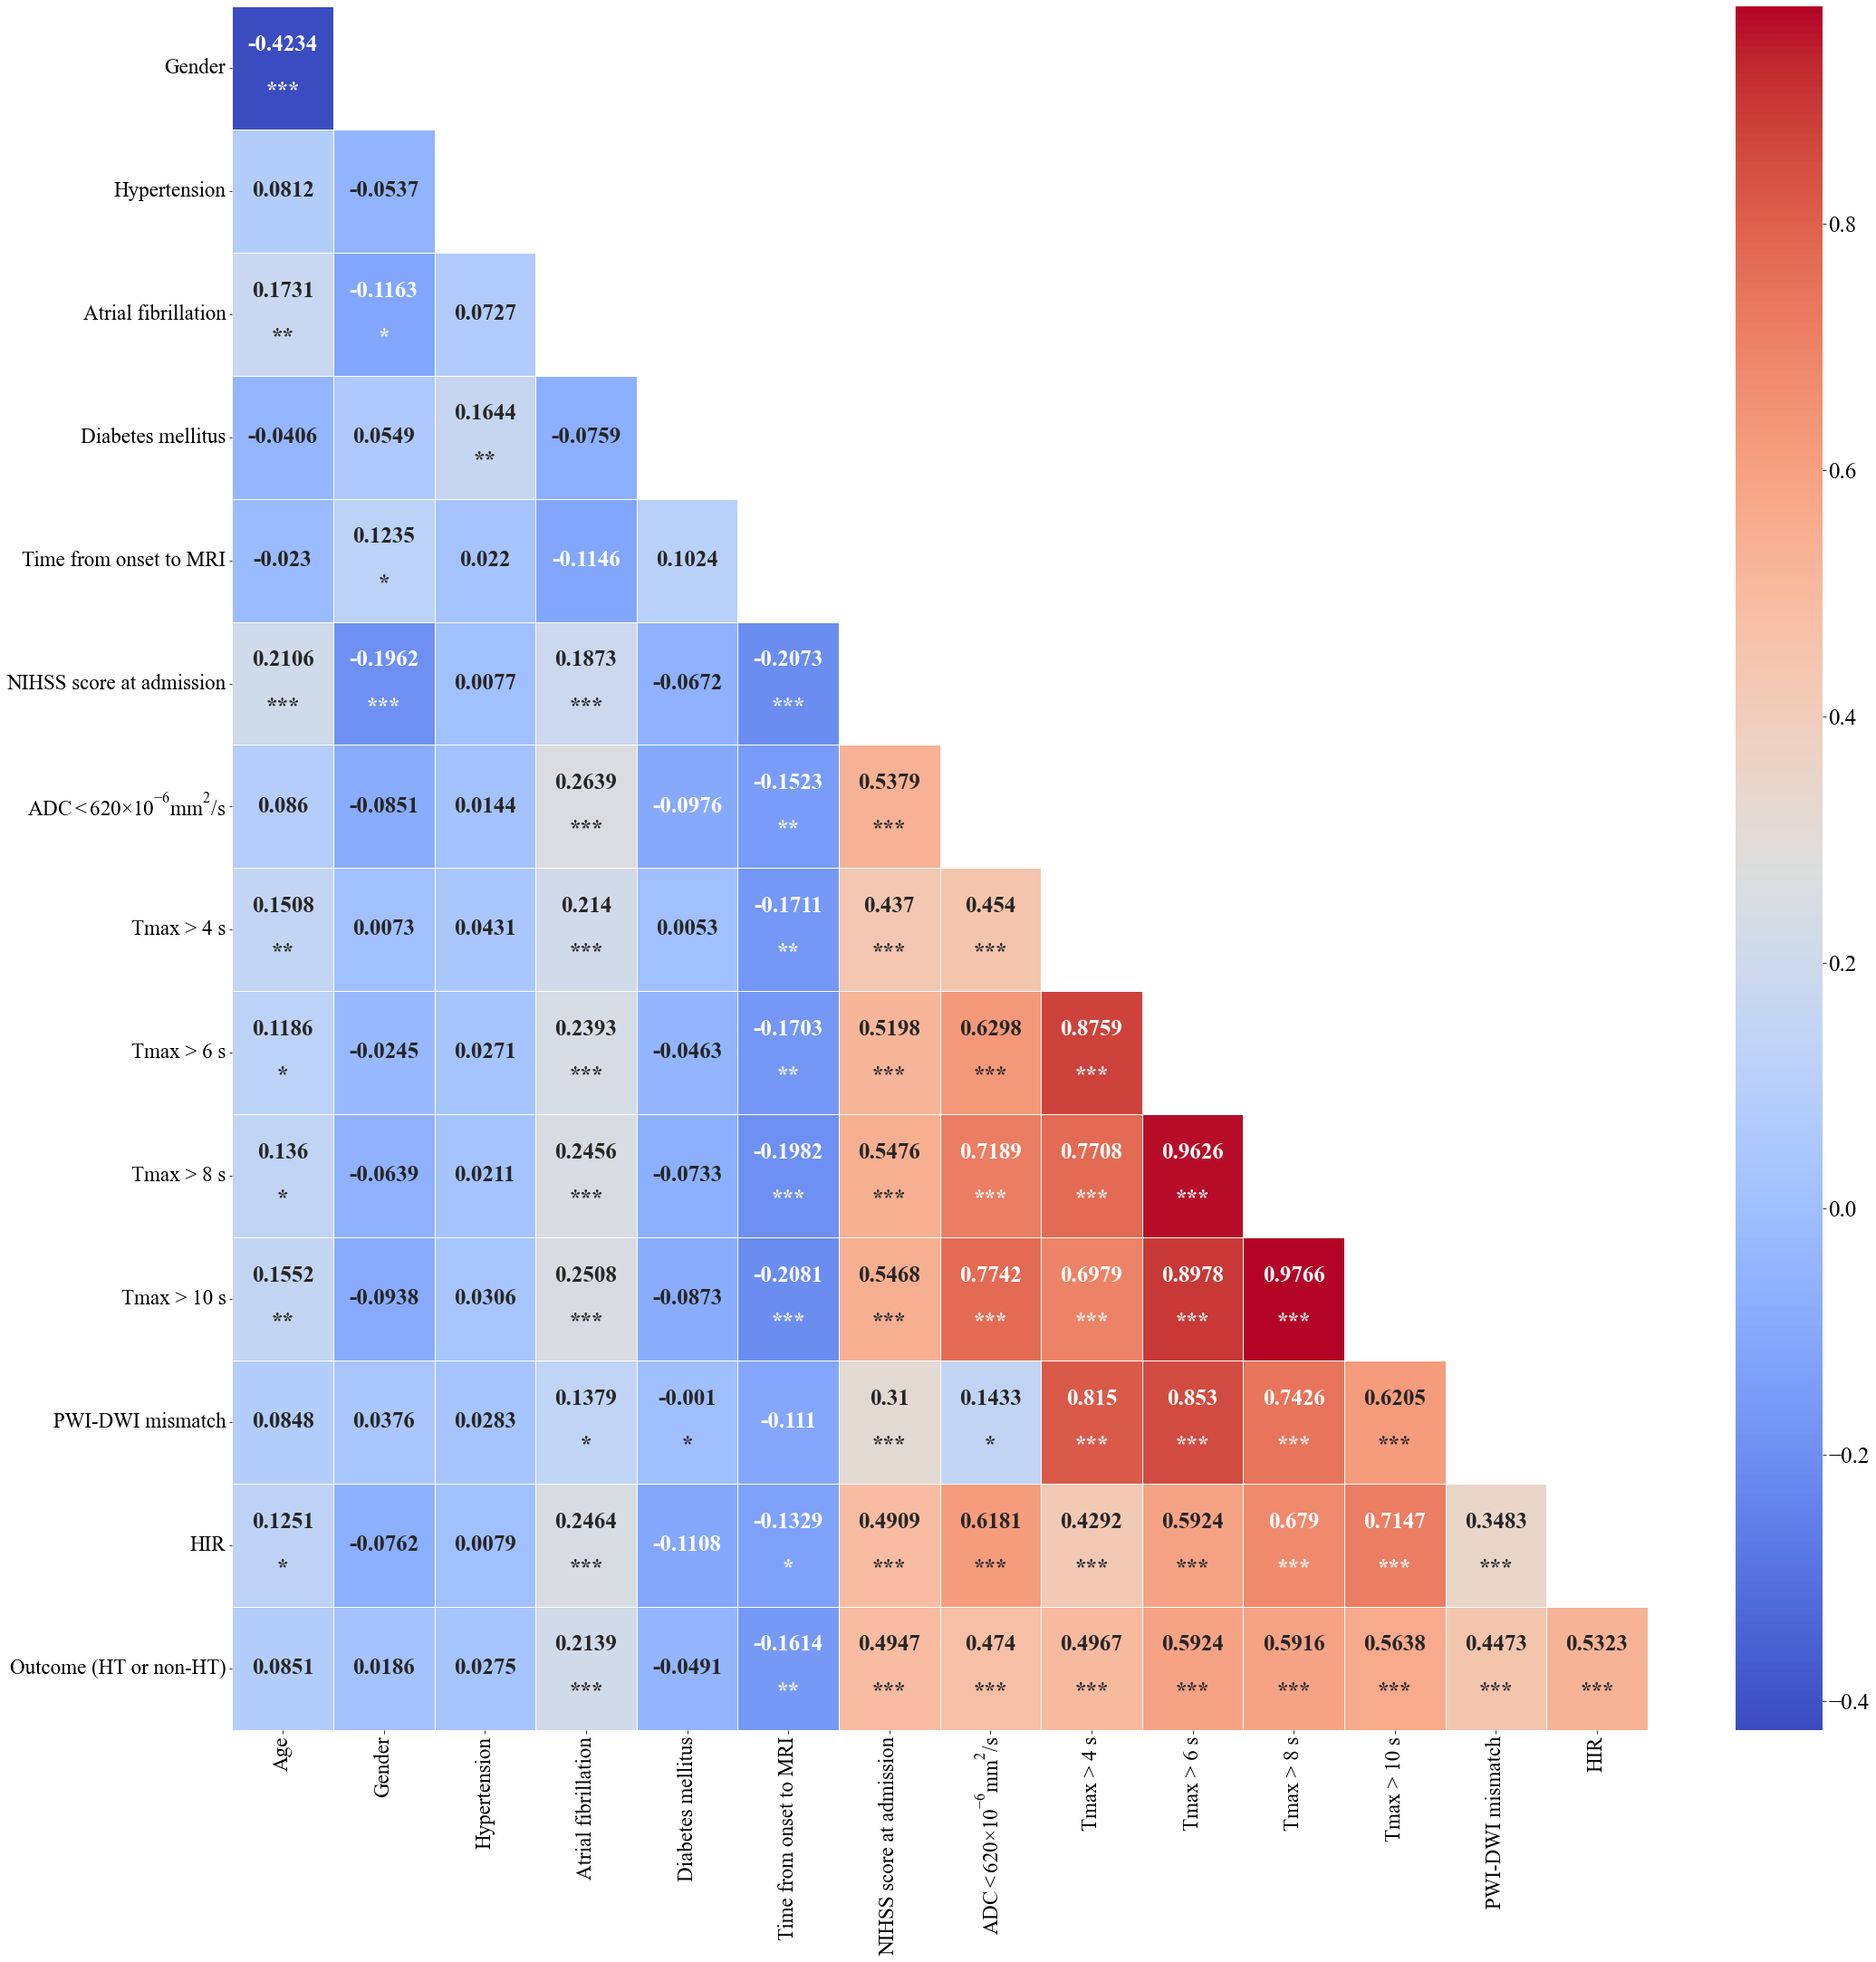

In [14]:
a = np.copy(correlation_matrix)[1:,:-1]
b = np.copy(correlation_pmatrix)[1:,:-1]
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if i <= j-1:
            a[i][j] = np.nan 
            b[i][j] = np.nan 

plt.figure(figsize=(35,35))

plt.rcParams['font.family'] = ['Times New Roman']
ax = sns.heatmap(a, 
            annot=b, 
            annot_kws={"fontsize":25,'fontweight':'bold'},
            xticklabels = xticklabel, #useful_data.columns[:-1],
            yticklabels = yticklabel, #useful_data.columns[1:],
            fmt = '',
            linewidth=.5,
            cmap='coolwarm')
plt.xticks(rotation=90,fontsize=23,ha='center',va='top')
plt.yticks(fontsize=23,rotation=0)
# plt.title('Correlation Matrix')
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=25)

plt.savefig('figures/correlation_matrix_version1.jpg')
plt.show()

### Correlation 2

In [15]:
## Correlation
useful_data = pd.DataFrame(df,columns=['Age','Gender','Hypertension', 'Atrial fibrillation','DM','TIME3', 
                                       'NIHSS', 'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume','Tmax>10 Volume', 
                                       'PWI-DWI Mismatch','VTmax>10s/VTmax>6s','Group'])
useful_data = useful_data.apply(lambda x:x.astype(float))
useful_data.head()


,Age,Gender,Hypertension,Atrial fibrillation,DM,TIME3,NIHSS,ADC<620,Tmax>4 Volume,Tmax>6 Volume,Tmax>8 Volume,Tmax>10 Volume,PWI-DWI Mismatch,VTmax>10s/VTmax>6s,Group
0,78.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0
1,79.0,1.0,1.0,0.0,0.0,7.5,1.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0
3,83.0,1.0,1.0,0.0,0.0,4.5,17.0,0.0,19.0,6.0,3.0,0.0,6.0,0.0,0.0
4,78.0,1.0,1.0,0.0,1.0,5.0,5.0,0.0,224.0,16.0,0.0,0.0,16.0,0.0,0.0


In [16]:
correlation_matrix = useful_data.corr()
correlation_matrix = np.array(correlation_matrix) 
correlation_matrix[np.triu_indices(correlation_matrix.shape[0], 1)] = np.nan
pvalue_matrix = useful_data.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
pvalue_matrix = pvalue_matrix.round(4)

## standard
## null hypothesis: not related 
## * : correlation is significant at 0.05 level (2 tailed)
## ** : correlation is significant at 0.01 level (2 tailed)
## *** : correlation is significant at 0.001 level (2 tailed)

correlation_pmatrix = np.array(correlation_matrix.round(4),dtype='str') 
pvalue_matrix = np.array(pvalue_matrix)
for i in range(correlation_pmatrix.shape[0]):
    for j in range(correlation_pmatrix.shape[1]):
        if i > j:
            if (pvalue_matrix[i][j] < 0.001/2) or (pvalue_matrix[i][j] > 1-0.001/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n***'
            elif (pvalue_matrix[i][j] < 0.01/2) or (pvalue_matrix[i][j] > 1-0.01/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n**'
            elif (pvalue_matrix[i][j] < 0.05/2) or (pvalue_matrix[i][j] > 1-0.05/2):
                correlation_pmatrix[i][j] = str(correlation_pmatrix[i][j]) + '\n\n*'
        
correlation_pmatrix = pd.DataFrame(correlation_pmatrix,columns=useful_data.columns)

In [17]:
xticklabel = ['Age', 'Gender', 'Hypertension', 'Atrial fibrillation', 'Diabetes mellitus', 'Time from onset to MRI',
       'NIHSS score at admission', '$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$', 'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s',
       'Tmax > 10 s', 'PWI-DWI mismatch', 'HIR','Outcome (HT or non-HT)']
yticklabel = ['Age','Gender', 'Hypertension', 'Atrial fibrillation', 'Diabetes mellitus',  'Time from onset to MRI', 'NIHSS score at admission',
       '$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$', 'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s',
       'Tmax > 10 s', 'PWI-DWI mismatch', 'HIR', 'Outcome (HT or non-HT)']

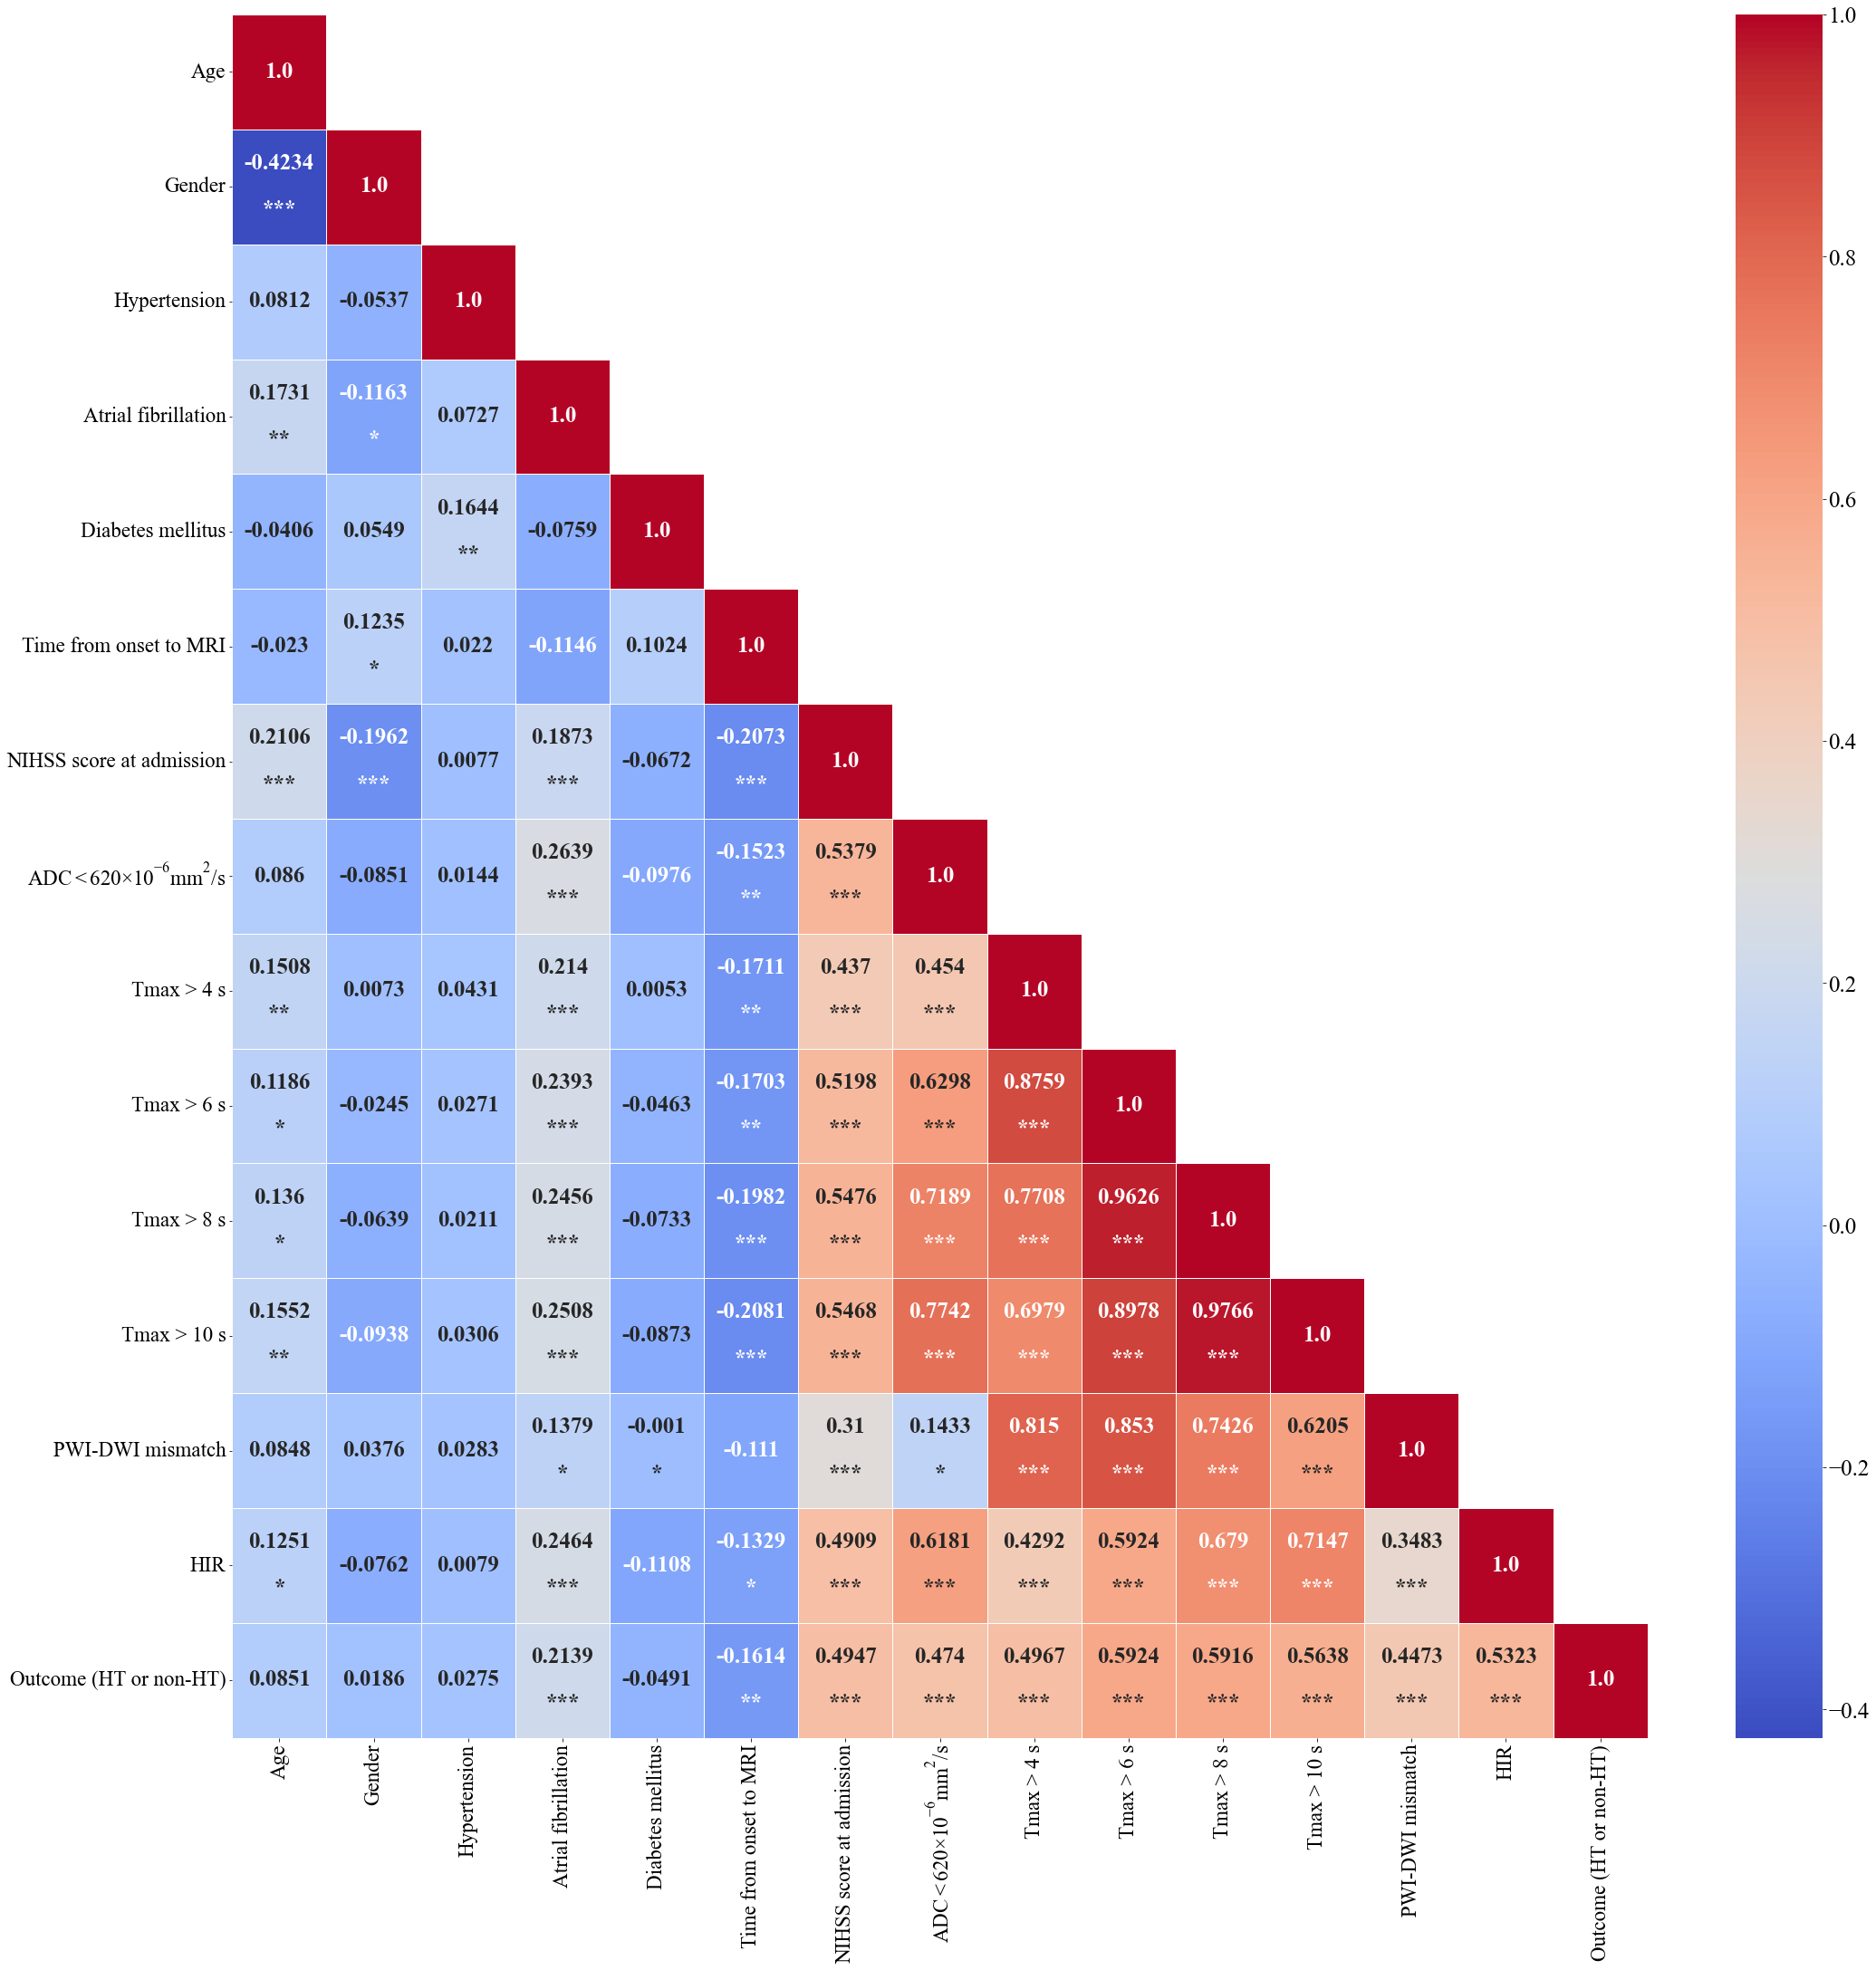

In [18]:
a = np.copy(correlation_matrix) 
b = np.copy(correlation_pmatrix) 
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if i <= j-1:
            a[i][j] = np.nan 
            b[i][j] = np.nan 

plt.figure(figsize=(35,35))
plt.rcParams['font.family'] = ['Times New Roman']

ax = sns.heatmap(a, 
            annot=b, 
            annot_kws={"fontsize":25,'fontweight':'bold'},
            xticklabels = xticklabel, #useful_data.columns[:-1],
            yticklabels = yticklabel, #useful_data.columns[1:],
            fmt = '',
            linewidth=.5,
            cmap='coolwarm')
plt.xticks(rotation=90,fontsize=23,ha='center',va='top')
plt.yticks(fontsize=23,rotation=0)
# plt.title('Correlation Matrix')

cax = ax.figure.axes[-1]
cax.tick_params(labelsize=25)

plt.savefig('figures/correlation_matrix_version2.jpg')
plt.show()